In [43]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
import glob
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV

In [44]:
import pandas as pd
import h5py
from os import listdir
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
import time

In [45]:
from cvxopt import matrix, solvers

## PREPROCESSING 
1.Preprocessing images into 72X96 dimension
2.To compute the HOG descriptor, we operate on 8x8 pixel cells within the detection window.
3.Within a cell, we compute the gradient vector at each pixel. We take the 64 gradient vectors (in our 8x8 pixel cell) and put   them into a 9-bin histogram.
4.The Histogram ranges from 0 to 180 degrees, so there are 20 degrees per bin.
5.For each gradient vector, it’s contribution to the histogram is given by the magnitude of the vector. 
6.We split the contribution between the two closest bins. So, for example, if a gradient vector has an angle of 85 degrees,    then we add 1/4th of its magnitude to the bin centered at 70 degrees, and 3/4ths of its magnitude to the bin centered at 90.

In [46]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        Visualise=False, feature_vec=True):
    
    if Visualise == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=Visualise, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=Visualise, feature_vector=feature_vec)
        

        return features

In [47]:
def get_spatial_features(img, size=(32, 32)):
    return cv2.resize(img, size).ravel() 

In [48]:
def get_hist_features(img, nbins=32, bins_range=(0, 256)):
    
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    return np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    

## EXTRACTING FEATURES OF HUMAN AND NON HUMAN

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


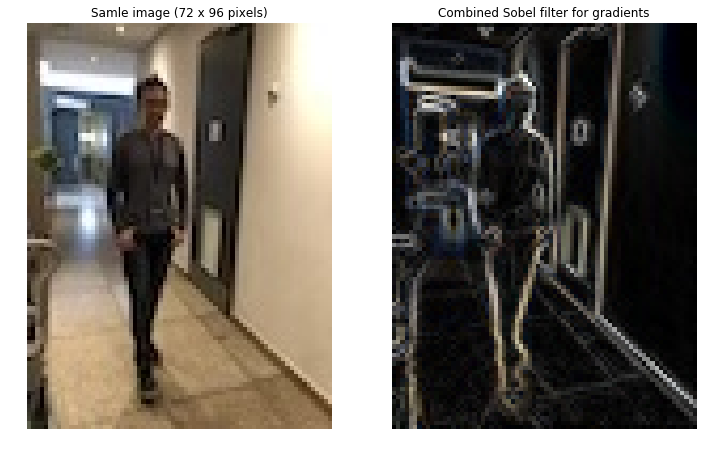

In [49]:
trial = cv2.imread(r'C:\Users\IRIN GEORGE\Desktop\personhog\Person-Detection-SVM-HOG-master\images\pos\pos_377.jpeg')
trial = cv2.cvtColor(trial, cv2.COLOR_BGR2RGB)
trial = np.float32(trial) / 255.0

gx = cv2.Sobel(trial, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(trial, cv2.CV_32F, 0, 1, ksize=1)

mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)

plt.figure(figsize=(12,9))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('Samle image (72 x 96 pixels)')
plt.imshow(trial)
plt.subplot(1,2,2)
plt.axis('off')
plt.title('Combined Sobel filter for gradients')
plt.imshow(mag)

In [50]:
human = glob.glob('C:/Users/IRIN GEORGE/Desktop/personhog/Person-Detection-SVM-HOG-master/images/pos/*.jpeg')
nothuman = glob.glob('C:/Users/IRIN GEORGE/Desktop/personhog/Person-Detection-SVM-HOG-master/images/neg/*.jpeg')
test=glob.glob('C:/Users/IRIN GEORGE/Desktop/first1/*.jpg')
hum=glob.glob('C:/Users/IRIN GEORGE/Desktop/first1/*.jpg')

In [51]:

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    features = []
    l=0
    
    for file in imgs:
        file_features = []
        
        
        image = cv2.imread(file)
        feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = get_spatial_features(feature_image, size=spatial_size)
            file_features.append(spatial_features)
            
        if hist_feat == True:
            hist_features = get_hist_features(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
            
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        Visualise=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, Visualise=False, feature_vec=True)
                
            

            file_features.append(hog_features)
            
       
        features.append(np.concatenate(file_features))
    
    print("Feature Vector Length",len(features[0]))
  
    return features

In [53]:
humans = glob.glob('C:/Users/IRIN GEORGE/Desktop/personhog/Person-Detection-SVM-HOG-master/images/pos/*.jpeg')
nothumans = glob.glob('C:/Users/IRIN GEORGE/Desktop/personhog/Person-Detection-SVM-HOG-master/images/neg/*.jpeg')

### Defining parameters 
color_space = 'RGB'
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # We are taking hog features in all colors
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Taking spatial features
hist_feat = True # Taking histogram features
hog_feat = True # Taking hog features
y_start_stop = [400, None] # minimum and maximum value ,will be used in sliding window


human_features = extract_features(humans, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
nothuman_features = extract_features(nothumans, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


Feature Vector Length 10320
Feature Vector Length 10320


In [54]:
X = np.vstack((human_features, nothuman_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(human_features)), np.zeros(len(nothuman_features))))

## VISUALIZING THE TRAINING DATA
 Human and Not human is shown

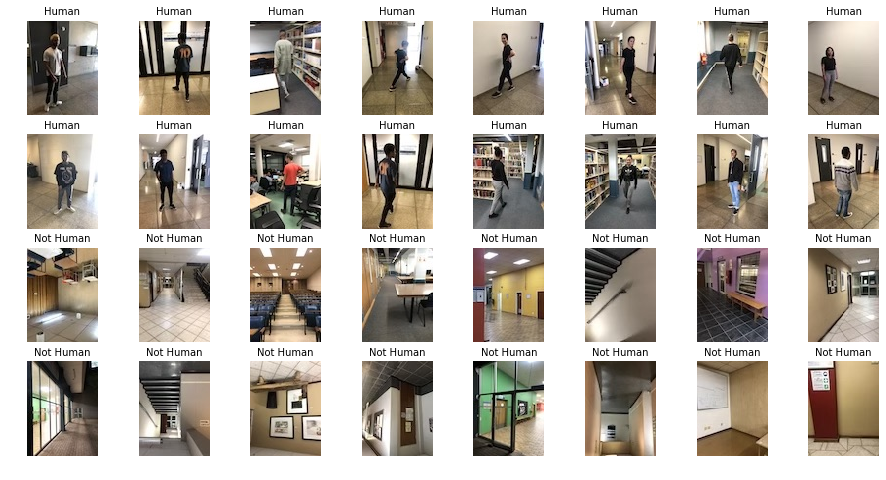

In [55]:
fig, axs = plt.subplots(4,8, figsize=(16, 8))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in np.arange(16):
    img = cv2.imread(humans[np.random.randint(0,len(humans))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Human', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(16,32):
    img = cv2.imread(nothumans[np.random.randint(0,len(nothumans))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Not Human', fontsize=10)
    axs[i].imshow(img)

## VISUALIZING THE HOG FEATURES

C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


Text(0.5, 1.0, 'Non-Human HOG')

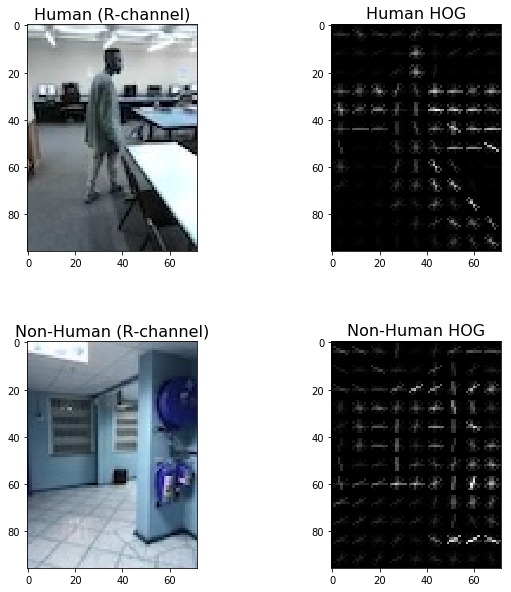

In [56]:
human = cv2.imread(humans[15])

_, human_dst = get_hog_features(human[:,:,0], 9, 8, 2, Visualise=True, feature_vec=True)

nothuman = cv2.imread(nothumans[15])
_, nonhuman_dst = get_hog_features(nothuman[:,:,0], 9, 8, 2, Visualise=True, feature_vec=True)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(human)
ax1.set_title('Human (R-channel)', fontsize=16)
ax2.imshow(human_dst, cmap='gray')
ax2.set_title('Human HOG', fontsize=16)
ax3.imshow(nothuman)
ax3.set_title('Non-Human (R-channel)', fontsize=16)
ax4.imshow(nonhuman_dst, cmap='gray')
ax4.set_title('Non-Human HOG', fontsize=16)

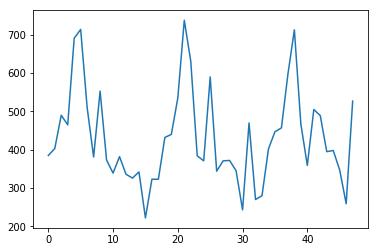

In [57]:
human = cv2.imread(humans[10])
cv2.imwrite("./output_images/sample_human.jpg", human)
hist = get_hist_features(human, nbins=hist_bins)
plt.plot(hist)
plt.show()

## Training a SVM

1. Spliting data into train and test with test size 20%.
2. Train model using SVM
3. Check accuracy of trained model on test data

In [58]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)


In [61]:
svc = LinearSVC()

In [62]:
svc.fit(X_train, y_train)
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.936


In [63]:
n_predict = 12
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])

My SVC predicts:  [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
For these 12 labels:  [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]


## Applying Heatmap

In [18]:
import imageio
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.heatmaps import HeatmapsOnImage



In [50]:
ia.seed(1)

image = cv2.imread(r'C:\Users\IRIN GEORGE\Desktop\neg11\f 4 sec.jpg')

depth = np.linspace(0, 50, 128).astype(np.float32)  
depth = np.tile(depth.reshape(1, 128), (128, 1))    

depth[64-2:64+2, 16:128-16] = 0.75 * 50.0  
depth[16:128-16, 64-2:64+2] = 1.0 * 50.0   

# Convert our numpy array depth map to a heatmap object.
depth = HeatmapsOnImage(depth, shape=image.shape, min_value=0.0, max_value=50.0)


depth = depth.avg_pool(2)

# Define our augmentation pipeline.
seq = iaa.Sequential([
    iaa.Dropout([0.05, 0.2]),      
    iaa.Sharpen((0.0, 1.0)),       
    iaa.Affine(rotate=(-45, 45)),  
    iaa.ElasticTransformation(alpha=50, sigma=5)  
], random_order=True)

# Augment images and heatmaps.
images_aug = []
heatmaps_aug = []
for _ in range(5):
    images_aug_i, heatmaps_aug_i = seq(image=image, heatmaps=depth)
    images_aug.append(images_aug_i)
    heatmaps_aug.append(heatmaps_aug_i)

cells = []
for image_aug, heatmap_aug in zip(images_aug, heatmaps_aug):
    cells.append(image)                                                    # column 1
    cells.append(image_aug)                                                # column 2
    cells.append(heatmap_aug.draw_on_image(image_aug)[0])                  # column 3
    cells.append(heatmap_aug.draw(size=image_aug.shape[:2])[0])            # column 4
    cells.append(heatmap_aug.draw(size=image_aug.shape[:2], cmap=None)[0]) # column 5

# Convert cells to grid image and save.
grid_image = ia.draw_grid(cells, cols=5)
imageio.imwrite(r'C:\Users\IRIN GEORGE\Desktop\neg11\f 4 sec.jpg', grid_image)